<a href="https://colab.research.google.com/github/katduecker/dnn_osci/blob/main/Thesis_ch3_one_layer_temporal_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/katduecker/dnn_osci
%cd dnn_osci
%cd aet_pytorch/

Cloning into 'dnn_osci'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 457 (delta 20), reused 5 (delta 2), pack-reused 413
Receiving objects: 100% (457/457), 36.08 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (238/238), done.
/content/dnn_osci
/content/dnn_osci/aet_pytorch


In [2]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

import aet_dyn
import aet_net
# get CUDA index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1]:
def euler_dyn(model,input_,params_,t_,alpha_params,DEVICE,inp_on):

    # inputs:
        # input_: input image
        # params_: hyperparameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude

    # discretization & dynamics parameters
    tau_h,tau_R,R,T,h_start,R_start = params_


    # alpha frequency & amplitude
    _af,_aa = alpha_params

    with torch.no_grad():

        # initialize empty matrices
        dt = np.diff(t_)[0]
        dhdt = (torch.ones((model.dims[1],len(t_)+1))*h_start).to(DEVICE)
        dRdt = (torch.ones((model.dims[1],len(t_)+1))*R_start).to(DEVICE)
        dOdt = (torch.zeros((model.dims[2],len(t_)+1))).to(DEVICE)
        dZdt = (torch.zeros((model.dims[1],len(t_)+1))).to(DEVICE)

        # alpha inhibition
        alpha_inh = _aa*np.sin(2*np.pi*_af*t_)+_aa

        # preactivation (dot product of input and first weight matrix)
        Z,_,_ = model.forw_conv(input_)

        # create boxcar function to try different input onsets
        boxcar = np.zeros_like(t_)
        boxcar[inp_on:] = 1

        # adjust initial adaptation term (threshold)
        dRdt *= torch.max(Z)

        # scale for adaptation
        #r_scale = R*torch.max(Z).detach()


        for _it,t in enumerate(t_):

            # dynamic input: multiply input with boxcar
            Z,_,_ = model.forw_conv(input_*boxcar[_it])

            # pre-activation
            dZdt[:,_it+1] = (Z + dhdt[:,_it] - dRdt[:,_it] - alpha_inh[_it])/T

            # dynamics hidden layer
            dhdt[:,_it+1] = dhdt[:,_it] + dt/tau_h * (-dhdt[:,_it] + model.acti1(dZdt[:,_it+1],model.sig_param))

            # adaptation term
            dRdt[:,_it+1] = dRdt[:,_it] + dt/tau_R * (-dRdt[:,_it] + R*np.mean(dZdt[:,_it+1])*dhdt[:,_it+1])
            #dRdt[:,_it+1] = dRdt[:,_it] + dt/tau_R * (-dRdt[:,_it] + sum(torch.round(dhdt[:,_it+1],decimals=3)>0)*dhdt[:,_it+1])
            # output layer
            dOdt[:,_it+1] = model.actiout(model.fc1(dhdt[:,_it+1]))

    return dZdt, dhdt, dRdt, dOdt


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


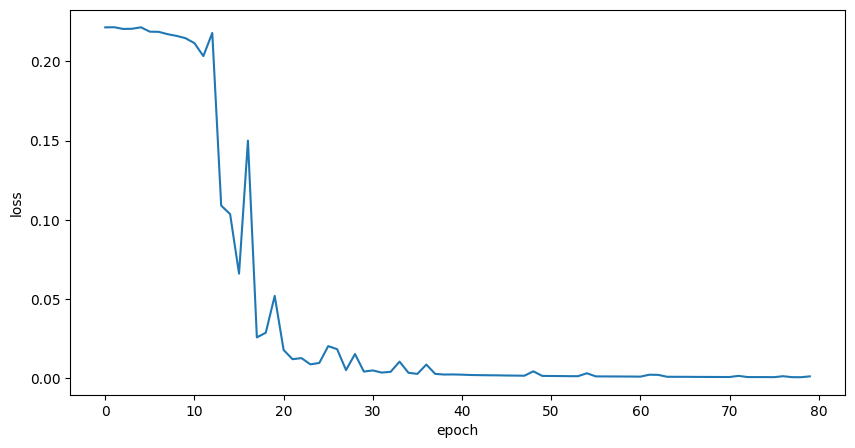

In [4]:
nn_dim_ = [28,68,3]   # [quadrant size, number of hidden nodes, number of output nodes]
eta_ = 0.1           # learning rate
mini_sz_ = 1          # mini batch size (1 = use SGD)
num_epo_ = 80

beta_ = 0
p_ = 0
kl_reg_ = [beta_,p_]#[0,0.001] # sparsity constraint parameters (not used for manual model)
sig_param = [2, -2.5] # sigmoid slope and shift in x direction

# loss function & final layer activation (for binary crossentropy use sigmoid)
lossfun = [nn.MSELoss(), nn.Softmax(dim=-1)]

params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param

# initialize model and weights
model = aet_net.net(params,lossfun)
model = aet_net.init_params(model,weight_init='uni')
optimizer = torch.optim.SGD(model.parameters(),lr=eta_)

model.to(DEVICE)
loss_hist = model.train(optimizer,noise=False,print_loss=False)


plt.rcParams["figure.figsize"] = (10,5)
plt.plot(np.arange(model.num_ep),loss_hist.cpu().detach().numpy())
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [5]:
# create stimuli
x_train, y_train = aet_net.aet_stim.mkstim()
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)

In [41]:
# dynamics

tau_h = 0.01
tau_r = 0.1
c = 3
S = 0.05
h_start = 0
R_start = 0
dyn_params = [tau_h,tau_r,c,S,h_start,R_start]   # [tau_h, tau_r, r_scale factor, T, h start, R start]

# dynamics alpha
aamp = 0.5
afreq = 10
aph = 0
alpha_params = [afreq,aamp]
_io = 0

timevec = np.linspace(0,0.6,600)

Zt,Ht, Rt, Ot  = aet_dyn.euler_dyn(model,x_train[0], dyn_params, timevec, alpha_params,DEVICE,inp_on=_io)

In [14]:
Z,H,O = model.forw_conv(x_train[0])

In [39]:


sum(torch.round(Ht[:,1],decimals=3)>0)

tensor(27)

In [45]:
plt.rcParams["figure.figsize"] = (24,90)

fig, axs = plt.subplots(Zt.shape[0],4)

t = 0

for i in range(Zt.shape[0]):
  axs[i,0].plot(timevec[t:],Zt[i,t+1:].detach().cpu().numpy())
  axs[i,0].set_yticks((-Z[i].detach().cpu().numpy(),0,Z[i].detach().cpu().numpy()))
  axs[i,0].set_ylabel('Z')
  axs[i,1].plot(Rt[i,t+1:].detach().cpu().numpy(),Zt[i,t+1:].detach().cpu().numpy())
  axs[i,1].set_xlabel('R')
  axs[i,1].set_ylabel('Z')

  axs[i,2].plot(timevec[t:],Ht[i,t+1:].detach().cpu().numpy())

  if aamp:
    axs[i,2].plot(timevec[t:],0.5*np.sin(2*np.pi*afreq*timevec[t:]+aph)+0.5,color = 'k',linestyle='-.')
  axs[i,2].fill_between(timevec[t:], np.tile(0,timevec[t:].shape[0]), np.tile(H[i].detach().cpu().numpy(),timevec[t:].shape[0]), alpha=0.15, color=[0, 0, 0])
  axs[i,2].set_ylabel('H')

  axs[i,2].set_ylim(0,1)
  axs[i,3].plot(Rt[i,t+1:].detach().cpu().numpy(),Ht[i,t+1:].detach().cpu().numpy())
  axs[i,3].set_ylim(0,1)
  axs[i,3].set_xlabel('R')
  axs[i,3].set_ylabel('H')

  fig.tight_layout()


KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7824923c2cb0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7824923c1f30> (for post_execute):


KeyboardInterrupt: ignored